## Medical Condition Classification

### Mathematics for Machine Learning and Deep Learning Project

-Kiki BEUMER, Yudita JOSEPH

### Import required library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import chi2_contingency, f_oneway
import plotly.graph_objects as go

### Initial Exploration

In [2]:
# Load dataset
med_df = pd.read_csv("medical_conditions_dataset.csv")
med_df=med_df.drop(columns=['full_name', 'id']) # Drop irrelevant columns
med_df.head()

age gender smoking_status        bmi  blood_pressure  glucose_levels  \
0   NaN   male     Non-Smoker        NaN             NaN             NaN   
1  30.0   male     Non-Smoker        NaN      105.315064             NaN   
2  18.0   male     Non-Smoker  35.612486             NaN             NaN   
3   NaN   male     Non-Smoker        NaN       99.119829             NaN   
4  76.0   male     Non-Smoker        NaN             NaN             NaN   

   condition  
0  Pneumonia  
1   Diabetic  
2  Pneumonia  
3  Pneumonia  
4   Diabetic

In [3]:
med_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             5445 non-null   float64
 1   gender          10000 non-null  object 
 2   smoking_status  10000 non-null  object 
 3   bmi             4652 non-null   float64
 4   blood_pressure  3766 non-null   float64
 5   glucose_levels  4756 non-null   float64
 6   condition       10000 non-null  object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


In [4]:
med_df.describe(include="all")

age gender smoking_status          bmi  blood_pressure  \
count   5445.000000  10000          10000  4652.000000     3766.000000   
unique          NaN      2              2          NaN             NaN   
top             NaN   male     Non-Smoker          NaN             NaN   
freq            NaN   8506           9014          NaN             NaN   
mean      53.541598    NaN            NaN    27.423420      135.209429   
std       20.925113    NaN            NaN     7.231257       26.041531   
min       18.000000    NaN            NaN    15.012119       90.009620   
25%       35.000000    NaN            NaN    21.077894      113.107754   
50%       54.000000    NaN            NaN    27.326204      134.821040   
75%       72.000000    NaN            NaN    33.689330      157.949509   
max       89.000000    NaN            NaN    39.998687      179.999359   

        glucose_levels condition  
count      4756.000000     10000  
unique             NaN         3  
top                NaN  Diabetic  
freq               NaN      6013  
mean        135.219608       NaN  
std          37.607638       NaN  
min          70.015961       NaN  
25%         102.273703       NaN  
50%         135.436764       NaN  
75%         168.349011       NaN  
max         199.890429       NaN

We visualize the distribution of the numerical features before and after we handle the missing values in the data

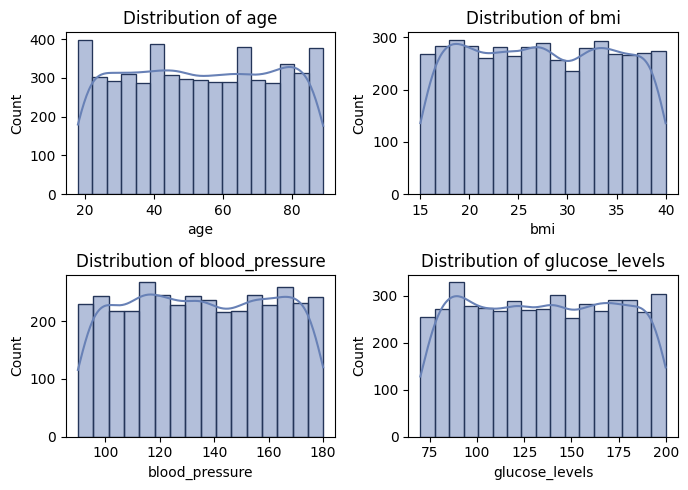

In [5]:
# Distribution of numerical features
num_features = ['age', 'bmi', 'blood_pressure', 'glucose_levels']

plt.figure(figsize=(7,5))

for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=med_df,
        x=col,
        kde=True,
        color="#6881b6",    
        edgecolor="#243559" 
    )
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [6]:
# Check for missing values
med_df.isna().sum()

age               4555
gender               0
smoking_status       0
bmi               5348
blood_pressure    6234
glucose_levels    5244
condition            0
dtype: int64

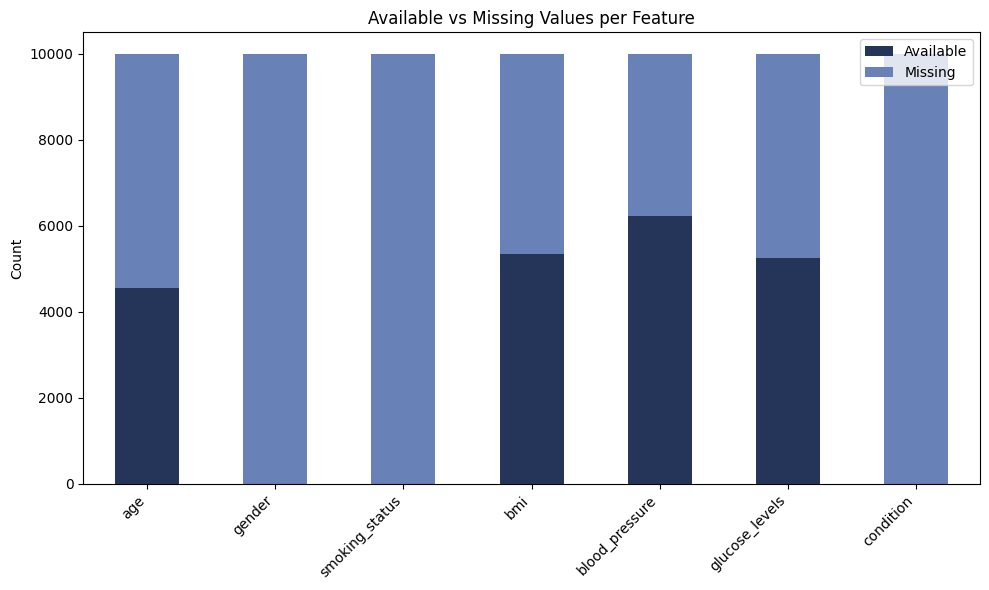

In [7]:
# Count missing and available values
summary = pd.DataFrame({'Available': med_df.isna().sum(),
                        'Missing': med_df.notna().sum()})

    # Plot
ax = summary.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#243559', '#6881b6'])

ax.set_ylabel("Count")
ax.set_title("Available vs Missing Values per Feature")
ax.legend(loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
    

We can see that a very large proportion of our data contains NaN values.

In [8]:
# # drop missing values
# med_df = med_df.dropna()
# med_df

Dropping these values would significantly reduce our sample zise (from 10000 to 446). This is why we rather decide to replace these values with the median, mean or the mode depending on the type of variable. Since the columns below are quantitative variables, we replace the missing values with the their median. 

In [9]:
# Handle missing values:

# continuous: median imputation
num_cols = ['age', 'bmi', 'blood_pressure', 'glucose_levels']
for col in num_cols:
    med_df[col] = med_df[col].fillna(med_df[col].median())


We can see that the distributions changed from almost uniform to Gaussian with large peaks around the median due to how we handled the missing data. 

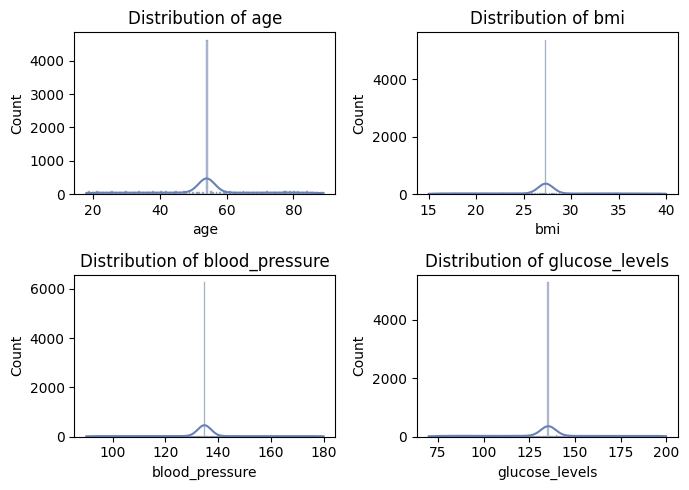

In [10]:
# Distribution of numerical features
num_features = ['age', 'bmi', 'blood_pressure', 'glucose_levels']

plt.figure(figsize=(7,5))

for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=med_df,
        x=col,
        kde=True,
        color="#6881b6",    
        edgecolor="#243559" 
    )
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [11]:
med_df['condition'].value_counts()

condition
Diabetic     6013
Pneumonia    2527
Cancer       1460
Name: count, dtype: int64

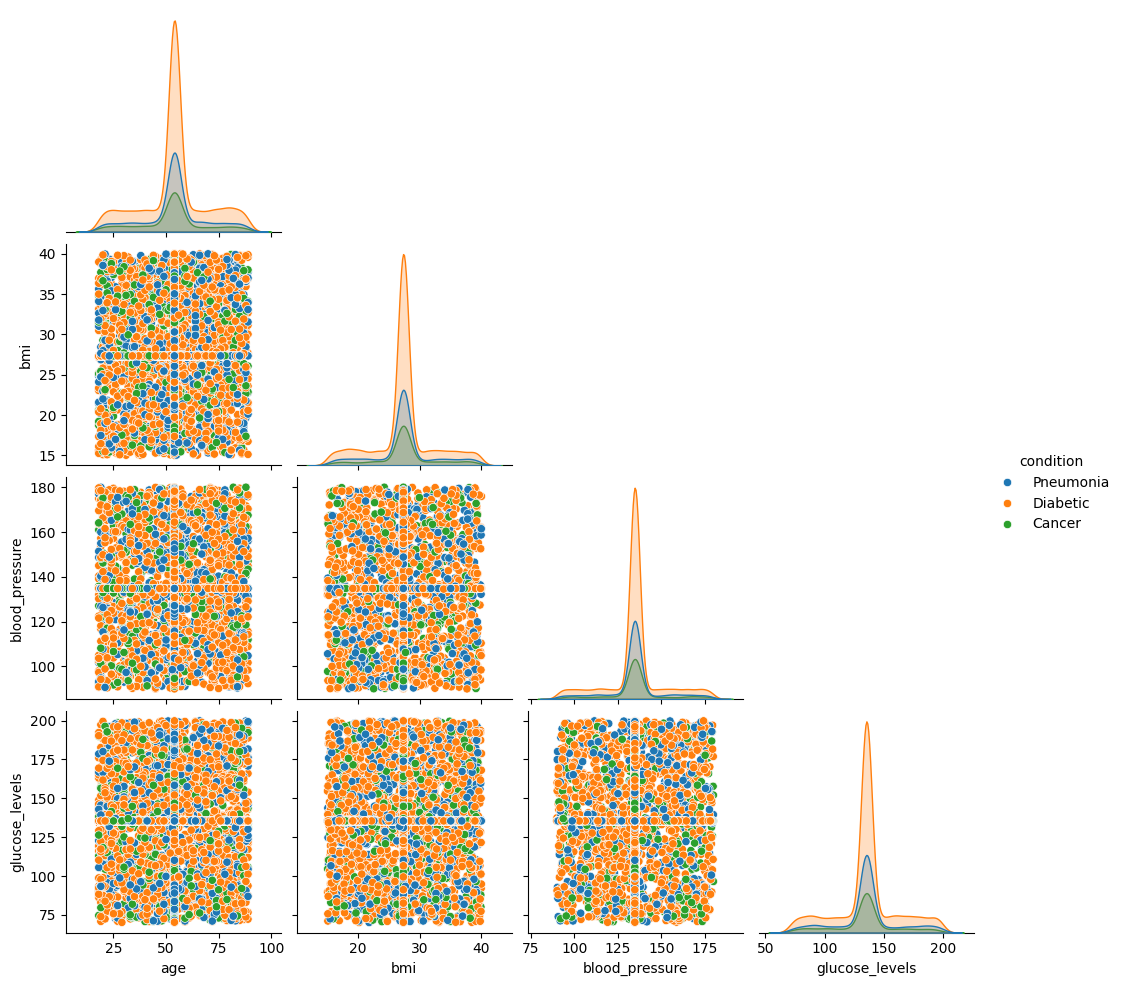

In [12]:
plot_df = med_df[['age', 'bmi', 'blood_pressure', 'glucose_levels', 'condition']]

# Pairplot 
sns.pairplot(plot_df, hue='condition', diag_kind='kde', corner=True)
plt.show()


These dotplots display a plus-shaped pattern in each plot, which results from replacing NaN values with the median.

### Correlation & Multicollinearity

The linear models such as Logistic regression, Linear Naive bayes and LDA rely on the assumption of low multicollinearity.

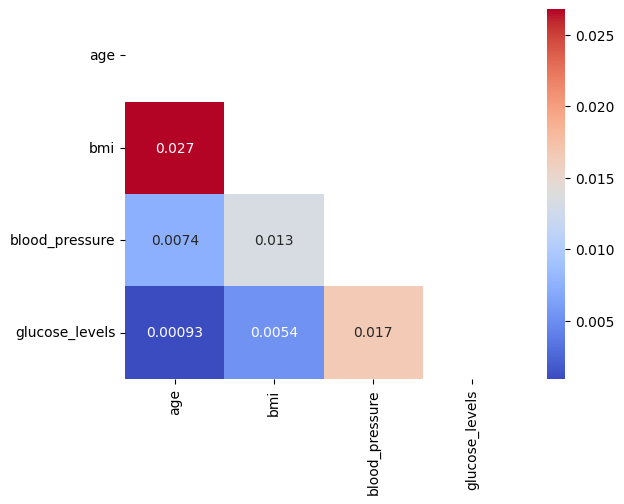

In [13]:
# Correlation heatmap
corr = med_df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.show()

Between the quantitative variables, there are indeed low correlations.

In [14]:
# Chi-square test (categorical vs categorical)
contingency_table = pd.crosstab(med_df['gender'], med_df['smoking_status'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Reject null: variables are dependent")
else:
    print("Fail to reject null: variables are independent")


Chi-square statistic: 3.1320829851779552
p-value: 0.07676559841377503
Fail to reject null: variables are independent


Chi-Squared also shows that the categorical variables are independent

In [15]:
# ANOVA test (numeric vs categorical) 
groups = [group['bmi'].values for name, group in med_df.groupby('condition')]
f_stat, p = f_oneway(*groups)

print("ANOVA F-statistic:", f_stat)
print("p-value:", p)
if p < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")


ANOVA F-statistic: 1.2628602941660174
p-value: 0.2828889696914734
No significant difference between groups


As well as ANOVA testing, showed us that there is no significant difference between groups

In [16]:
# VIF (multicollinearity check)
X_numeric = med_df[num_cols].astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

          feature        VIF
0             age  12.110745
1             bmi  25.302626
2  blood_pressure  36.578304
3  glucose_levels  23.027971


Checking for multicollinearity between numeric features, we observe that the VIF values are greater than 10, indicating high collinearity. Violating the multicollinearity assumptions affects the linear models such as logistic regression and linear SVM, while tree based model or neural network are generally less affected by multicollinearity.

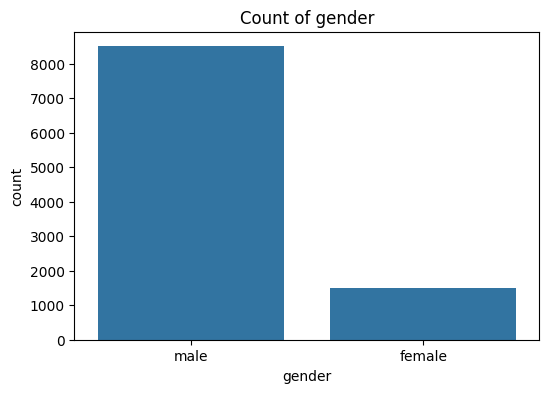

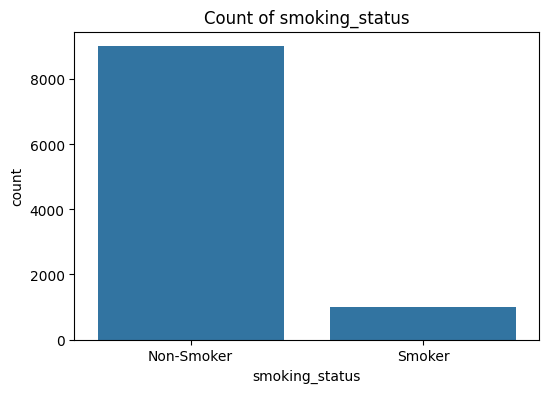

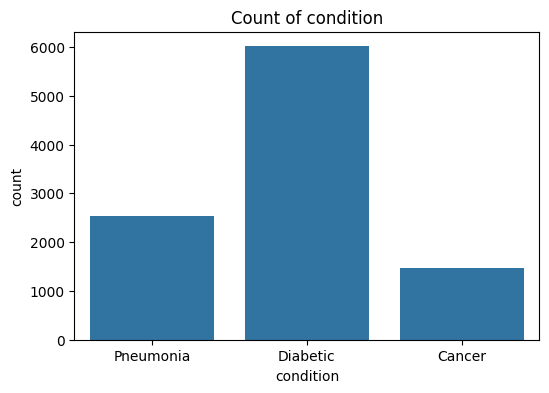

In [17]:
# Categorical countplots
cat_cols = ['gender', 'smoking_status', 'condition']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=med_df)
    plt.title(f'Count of {col}')
    plt.show()


Since the data is highly imbalanced, modeling on this dataset may lead to misleading accuracy and bias towards the majority class or recall for rare diseases or minority classes may drop fastly.

In [18]:
print(med_df.groupby(['condition', 'gender', 'smoking_status']).size())

condition  gender  smoking_status
Cancer     female  Non-Smoker         195
                   Smoker              15
           male    Non-Smoker        1128
                   Smoker             122
Diabetic   female  Non-Smoker         814
                   Smoker              79
           male    Non-Smoker        4596
                   Smoker             524
Pneumonia  female  Non-Smoker         357
                   Smoker              34
           male    Non-Smoker        1924
                   Smoker             212
dtype: int64


One way to handle imbalanced dataset is by either oversampling minority groups or undersampling majority groups.

Oversampling:

In [19]:
# Determine target size per subgroup
target_size = 1000

balanced_df = pd.DataFrame()

# Loop over each combination of condition, gender, smoking_status
for (cond, gender, smoke), group in med_df.groupby(['condition', 'gender', 'smoking_status']):
    resampled_group = resample(group,
                               replace=True,
                               n_samples=target_size,
                               random_state=42)
    balanced_df = pd.concat([balanced_df, resampled_group])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df.groupby(['condition', 'gender', 'smoking_status']).size())


condition  gender  smoking_status
Cancer     female  Non-Smoker        1000
                   Smoker            1000
           male    Non-Smoker        1000
                   Smoker            1000
Diabetic   female  Non-Smoker        1000
                   Smoker            1000
           male    Non-Smoker        1000
                   Smoker            1000
Pneumonia  female  Non-Smoker        1000
                   Smoker            1000
           male    Non-Smoker        1000
                   Smoker            1000
dtype: int64


To balance all combinations of condition × gender × smoking_status, we oversampled minority subgroups with replacement. This means rows from tiny groups (e.g., Female Smokers with only 15 samples) are duplicated until each subgroup reaches the target size (e.g., 1000). This removes imbalance but may cause overfitting if the target size is large or may underfit the model if the target size is too small.

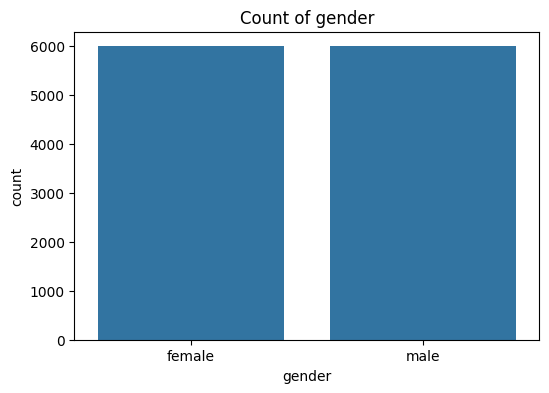

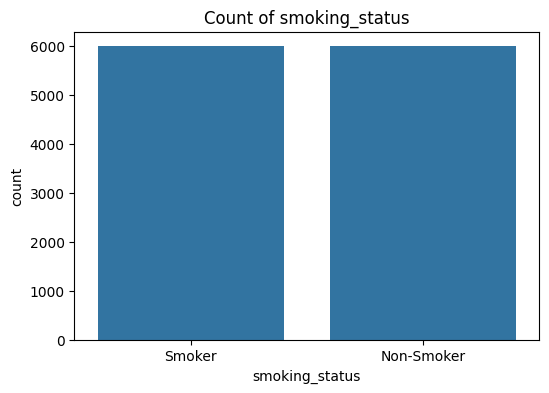

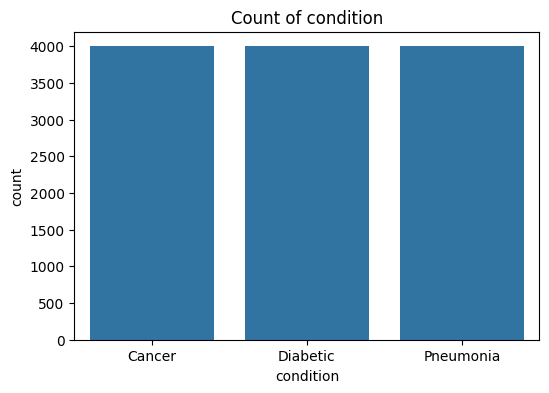

In [20]:
cat_cols = ['gender', 'smoking_status', 'condition']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=balanced_df)
    plt.title(f'Count of {col}')
    plt.show()

Undersampling:

In [21]:
# Find the smallest subgroup size
min_size = med_df.groupby(['condition', 'gender', 'smoking_status']).size().min()
print(f"Smallest subgroup size: {min_size}")

undersampled_df = pd.DataFrame()

# Undersample each subgroup to min_size
for (cond, gender, smoke), group in med_df.groupby(['condition', 'gender', 'smoking_status']):
    undersampled_group = resample(group,
                                  replace=False,   # no duplicates
                                  n_samples=min_size,
                                  random_state=42)
    undersampled_df = pd.concat([undersampled_df, undersampled_group])

# Shuffle
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check counts
print(undersampled_df.groupby(['condition', 'gender', 'smoking_status']).size())


Smallest subgroup size: 15
condition  gender  smoking_status
Cancer     female  Non-Smoker        15
                   Smoker            15
           male    Non-Smoker        15
                   Smoker            15
Diabetic   female  Non-Smoker        15
                   Smoker            15
           male    Non-Smoker        15
                   Smoker            15
Pneumonia  female  Non-Smoker        15
                   Smoker            15
           male    Non-Smoker        15
                   Smoker            15
dtype: int64


Undersampling balances all subgroups by reducing the size of majority groups to match the smallest subgroup (e.g., Female Smokers). No duplicates are created, but this reduces the total data available for training.

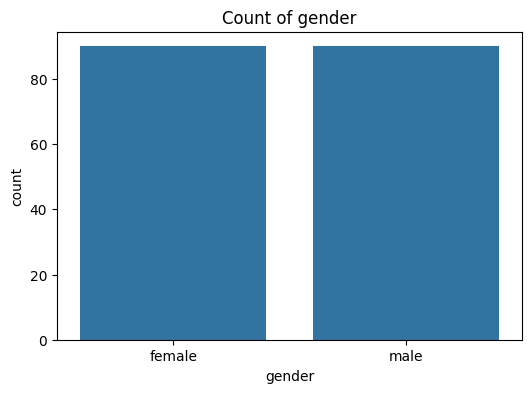

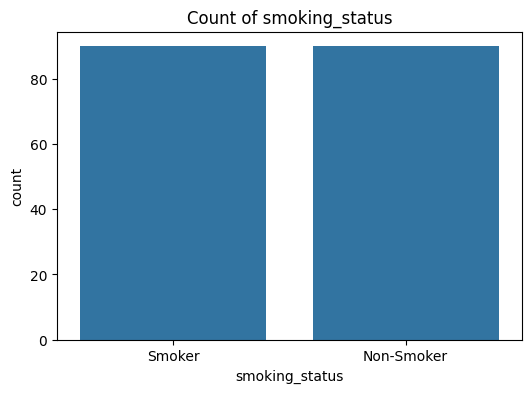

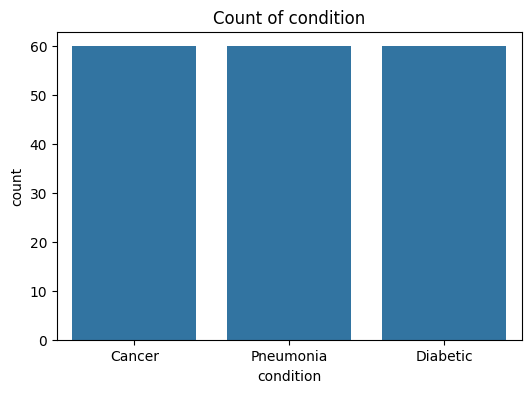

In [22]:
cat_cols = ['gender', 'smoking_status', 'condition']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=undersampled_df)
    plt.title(f'Count of {col}')
    plt.show()

---

We will perform model training and evaluating on both the imbalanced and the balanced dataset. We will then compare which models perform best for each dataset.

# Imbalanced data

### Encoding features

In [23]:
# One-hot encode categorical features
X = med_df.drop('condition', axis=1)
X = pd.get_dummies(X, columns=['gender', 'smoking_status'], drop_first=True, dtype=int)  # drop_first avoids multicollinearity
X.head()

age        bmi  blood_pressure  glucose_levels  gender_male  \
0  54.0  27.326204      134.821040      135.436764            1   
1  30.0  27.326204      105.315064      135.436764            1   
2  18.0  35.612486      134.821040      135.436764            1   
3  54.0  27.326204       99.119829      135.436764            1   
4  76.0  27.326204      134.821040      135.436764            1   

   smoking_status_Smoker  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [24]:
# Encode target variable (condition) as numbers
y = med_df['condition']
le = LabelEncoder()
y = le.fit_transform(y)  # Cancer=0, Diabetic=1, Pneumonia=2

print(med_df['condition'][:5])
print(y[:(5)])

0    Pneumonia
1     Diabetic
2    Pneumonia
3    Pneumonia
4     Diabetic
Name: condition, dtype: object
[2 1 2 2 1]


### Train-test split

In [25]:
# Train/Validation/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

In [26]:
# Scaling numeric features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Model training & evaluation

In [27]:
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF)": SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
}

In [28]:
# Train on training set, evaluate on validation
results_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='macro')
    prec = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred_val, average='macro')
    
    results_list.append({
        "Model": name,
        "Accuracy": round(acc, 2),
        "F1-score": round(f1, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2)
    })

results_df = pd.DataFrame(results_list).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print(results_df)


                 Model  Accuracy  F1-score  Precision  Recall
0  Logistic Regression      0.60      0.25       0.20    0.33
1          Naive Bayes      0.60      0.25       0.20    0.33
2            SVM (RBF)      0.60      0.25       0.20    0.33
3    Gradient Boosting      0.59      0.26       0.30    0.33
4              XGBoost      0.57      0.26       0.29    0.32
5       Neural Network      0.56      0.27       0.31    0.32
6        Random Forest      0.50      0.32       0.33    0.33
7        Decision Tree      0.46      0.33       0.33    0.33


We will loop over all models, we would like to compare and calculate their accuracy, F1-score, Precision and recall. SInce we are dealing with imbalanced data, it would be best to look at the F1-score rather than the accuracy. We can see that the decision tree and the random forest perform best. However, all models seem to perform badly. Indeed, the accuracy meatric for imbalanced data can be misleading. This output is a good example of that. 

---

# Balanced data

We will again encode the condition column and seperate the data in testing and training data

### Encoding features

In [29]:
# One-hot encode categorical features
X = balanced_df.drop('condition', axis=1)
X = pd.get_dummies(X, columns=['gender', 'smoking_status'], drop_first=True, dtype=int)

In [30]:
# Encode target variable (condition) as numbers
y = balanced_df['condition']
le = LabelEncoder()
y = le.fit_transform(y)  # Cancer=0, Diabetic=1, Pneumonia=2

### Train-test split

In [31]:
# Train/Validation/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)
# 60% train, 20% val, 20% test

In [32]:
# Scaling numeric features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Model training & evaluation

In [33]:
# Train on training set, evaluate on validation
results_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='macro')
    prec = precision_score(y_val, y_pred_val, average='macro')
    rec = recall_score(y_val, y_pred_val, average='macro')
    
    results_list.append({
        "Model": name,
        "Accuracy": round(acc, 2),
        "F1-score": round(f1, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2)
    })

results_df = pd.DataFrame(results_list).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print(results_df)


                 Model  Accuracy  F1-score  Precision  Recall
0        Decision Tree      0.78      0.78       0.78    0.78
1        Random Forest      0.78      0.78       0.78    0.78
2              XGBoost      0.66      0.66       0.66    0.66
3    Gradient Boosting      0.62      0.62       0.62    0.62
4       Neural Network      0.62      0.62       0.62    0.62
5            SVM (RBF)      0.49      0.49       0.49    0.49
6          Naive Bayes      0.38      0.35       0.39    0.38
7  Logistic Regression      0.36      0.36       0.36    0.36


c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


We can see that the model performs better on the balanced data. Again, Decision tree and Random forest perform best. We will discuss in the report why these simpler models perform better than XGBoost or Gradient Boosting. 

## Hyperparameter tuning

### Logistic Regression 

Next, we will perform Logistic regression with regularization using L1, L2, or Elastic Net penalties. A grid search tunes the regularization strength (`C`) and style (`penalty` and `l1_ratio`) to prevent overfitting and improve performance. The best-scoring model is then selected and used to make predictions. 


In [34]:
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

# Tuning parameter C with grid search
params = {'C':[0.01,0.1,0.5,1,5], 'penalty':['l1','l2','elasticnet'], 'l1_ratio':[0,0.5,1]}
grid_lr = GridSearchCV(lr, params, scoring='f1_macro', cv=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Use the optimal value for the parameter
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Best LR params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr))

Best LR params: {'C': 0.01, 'l1_ratio': 1, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       800
           1       0.36      0.43      0.39       800
           2       0.36      0.23      0.28       800

    accuracy                           0.36      2400
   macro avg       0.36      0.36      0.36      2400
weighted avg       0.36      0.36      0.36      2400



c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


The best scoring parameters were C= 0.01 and penalty = L2. These will be used to make predicitons. 

### Neural Network

Next we do a grid search to find the optimal parameters in the neural network model. It tunes its hidden layer sizes, regularization strength (`alpha`), and learning rate to reduce overfitting. Grid search selects the best hyperparameter combination based on `f1_macro` score.

In [35]:
nn = MLPClassifier(max_iter=500, random_state=42)
nn_params = {
    'hidden_layer_sizes': [(100,100,100), (100,100,100,100), (100,100,100,100,100)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init':[0.001,0.01]
}

# Gridsearch
grid_nn = GridSearchCV(nn, nn_params, scoring='f1_macro', cv=3, n_jobs=-1)
grid_nn.fit(X_train, y_train)

best_nn = grid_nn.best_estimator_
y_pred_nn = best_nn.predict(X_test)
print("Neural Network best params:", grid_nn.best_params_)
print(classification_report(y_test, y_pred_nn))

Neural Network best params: {'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100, 100), 'learning_rate_init': 0.001}
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       800
           1       0.70      0.67      0.68       800
           2       0.65      0.76      0.70       800

    accuracy                           0.69      2400
   macro avg       0.70      0.69      0.69      2400
weighted avg       0.70      0.69      0.69      2400



### XGBoost

We find optimal parameter values: alpha = 0.001, hidden layer sizes = (100, 100, 100, 100), which means that we have 4 hidden layers containing 100 neurons each. The model's performance is optimal at a learning rate = 0.001.  

In [36]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1]
}
grid_search = GridSearchCV(xgb, param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:19:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       800
           1       0.73      0.70      0.71       800
           2       0.73      0.77      0.75       800

    accuracy                           0.75      2400
   macro avg       0.75      0.75      0.75      2400
weighted avg       0.75      0.75      0.75      2400



In XGBoost classifier the hyperparameters that are tuned are tree depth, learning rate, number of estimators, subsampling, etc. Grid search evaluates every parameter combination and selects the one that produces the best `f1_macro` score. The best model is then used to generate predictions and return the performance metrics. 


The optimal returned values were: colsample_bytree = 1.0 which means that 100 % of the features per tree were utilized when building each tree. Furthermore, maximum tree depth = 7, number of estimators used were 300. Subsample= 0.7, shows that 70% of the training data were used to build the tree. 

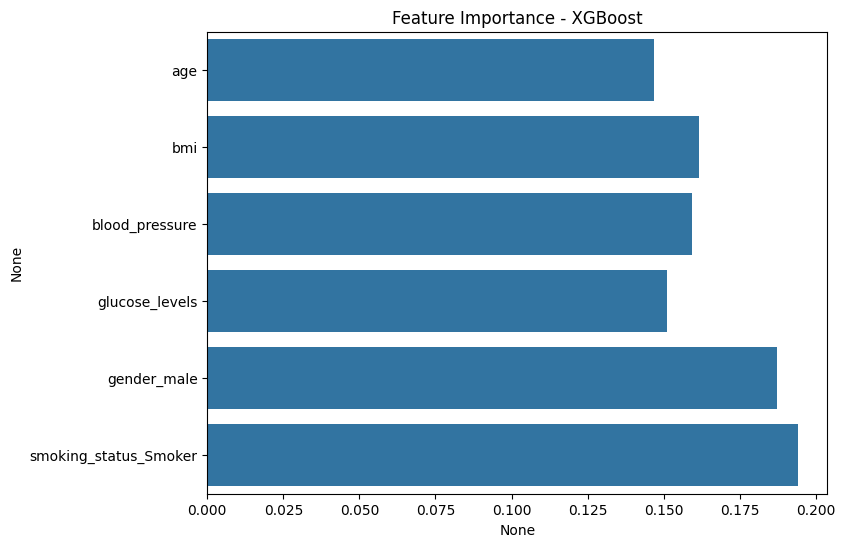

In [37]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    eval_metric='mlogloss'  # avoids warning
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance - XGBoost")
plt.show()

Looking further into the feature importance used when modeling XGBoost gives the barplot above. We can see that smoking status as well as gender have high importance; they contribute the most to the model's predictions.

### Decision Tree

In [38]:
dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [1, 3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_grid = GridSearchCV(
    dt,
    param_grid=dt_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Best DT params:", dt_grid.best_params_)
print(classification_report(y_test, y_pred_dt))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best DT params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       800
           1       0.77      0.71      0.74       800
           2       0.79      0.78      0.79       800

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



The optimal Decision Tree parameters found are max_depth = None, min_samples_split = 2, and min_samples_leaf = 1. This means the tree can grow without depth restriction, splits if a node has at least 2 samples, and leaves can have as few as 1 sample. These settings let the tree to fully fit the training data, which can capture complex patterns but may lead to overfitting.


### Random Forest

In [39]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [12, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.8]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best RF params:", rf_grid.best_params_)
print(classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best RF params: {'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       800
           1       0.75      0.75      0.75       800
           2       0.80      0.79      0.79       800

    accuracy                           0.79      2400
   macro avg       0.79      0.79      0.79      2400
weighted avg       0.79      0.79      0.79      2400



The optimal Random Forest parameters are max_depth = 20, max_features = 0.8, min_samples_leaf = 1,  min_samples_split = 2, and n_estimators = 600. This means each tree can grow up to 20 levels, it also considers 80% of features when splitting. The model also allows leaves with minimum  1 sample, and splits nodes with at least 2 samples. 

### Performance Metrics before and after hyperparameter tuning

In [40]:
# Store old (untuned) results
old_results_list = []

for name, model in models.items():
    y_pred_val = model.predict(X_val) 
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='macro')
    
    old_results_list.append({
        "Model": name,
        "Accuracy_old": round(acc, 2),
        "F1_old": round(f1, 2)
    })

old_results_df = pd.DataFrame(old_results_list)

new_results_list = []

for name, best_model in zip(
        ["Logistic Regression","Neural Network","Decision Tree","Random Forest","XGBoost"],
        [best_lr, best_nn, best_dt, best_rf, best_xgb]):
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    new_results_list.append({
        "Model": name,
        "Accuracy_new": round(acc, 2),
        "F1_new": round(f1, 2)
    })

new_results_df = pd.DataFrame(new_results_list)

compare_df = old_results_df.merge(new_results_df, on="Model")
print(compare_df)


                 Model  Accuracy_old  F1_old  Accuracy_new  F1_new
0  Logistic Regression          0.36    0.36          0.36    0.36
1        Decision Tree          0.78    0.78          0.78    0.78
2        Random Forest          0.78    0.78          0.79    0.79
3              XGBoost          0.66    0.66          0.75    0.75
4       Neural Network          0.62    0.62          0.69    0.69


From the initial results, tree-based models (Random Forest, Decision Tree) performed the best, while Logistic Regression and Neural Networks were underperforming. We chose to focus the tuning on models where regularization or hyperparameter optimization could meaningfully improve performance: Logistic Regression, Neural Network, XGBoost, Random Forest, and Decision Tree. Hyperparameter tuning allowed us to slightly improve the strongest performers and boost the weakest models.
Due to computational constraints, we did not explore all possible hyperparameter combinations, so we can not say for certain if we optained the  absolute optimal performance. Nevertheless, these improvements provide insight into model sensitivity and confirm that tree-based models (Decision tree and Random Forest) are the optimal model for this dataset.

In [41]:
def plot_decision_boundary(df, feat1, feat2, target_col, model, colors=None, grid_size=300):
    X_plot = df[[feat1, feat2]]
    y_plot = df[target_col]

    # Encode target
    le = LabelEncoder()
    y_enc = le.fit_transform(y_plot)
    class_names = le.classes_

    # Default colors if not provided
    if colors is None:
        default_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
        colors = {i: default_colors[i % len(default_colors)] for i in range(len(class_names))}

    # Train the model
    model.fit(X_plot, y_enc)

    # Create grid
    x_min, x_max = X_plot[feat1].min() - 1, X_plot[feat1].max() + 1
    y_min, y_max = X_plot[feat2].min() - 1, X_plot[feat2].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Build figure
    fig = go.Figure()

    # Add decision boundary as heatmap (discrete colors)
    fig.add_trace(go.Heatmap(
        x=np.linspace(x_min, x_max, 300),
        y=np.linspace(y_min, y_max, 300),
        z=Z,
        colorscale=[
            [0.0, colors[0]],
            [0.33, colors[0]],
            [0.34, colors[1]],
            [0.66, colors[1]],
            [0.67, colors[2]],
            [1.0, colors[2]]
        ],
        opacity=0.30,
        showscale=False
    ))

    # Add actual data points
    fig.add_trace(go.Scatter(
        x=X_plot[feat1],
        y=X_plot[feat2],
        mode='markers',
        marker=dict(
            size=6,
            color=[colors[i] for i in y_enc],
            line=dict(color='white', width=0.6),
            opacity=0
        ),
        text=[f"Class: {c}" for c in y_plot],
        hoverinfo="text",
        showlegend=False
    ))

    # Add manual legend
    for class_idx, class_name in enumerate(class_names):
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=10, color=colors[class_idx]),
            name=class_name
        ))

    fig.update_layout(
        title="Decision Boundary",
        xaxis_title=feat1,
        yaxis_title=feat2,
        height=600
    )

    
    fig.show()


In [42]:
plot_decision_boundary(
    balanced_df,
    feat1='age',
    feat2='bmi',
    target_col='condition',
    model=RandomForestClassifier(max_depth=20, max_features=0.8,min_samples_leaf=1,min_samples_split=2,n_estimators=600,random_state=42))

c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [43]:
plot_decision_boundary(
    balanced_df,
    feat1='age',
    feat2='bmi',
    target_col='condition',
    model=DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
))

c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [44]:
plot_decision_boundary(
    balanced_df,
    feat1='age',
    feat2='bmi',
    target_col='condition',
    model=XGBClassifier(
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=300,
    subsample=0.7,
    random_state=42,
    eval_metric='mlogloss'
))

In [45]:
plot_decision_boundary(
    balanced_df,
    feat1='age',
    feat2='bmi',
    target_col='condition',
    model=MLPClassifier(
    alpha=0.001,
    hidden_layer_sizes=(100, 100, 100, 100),
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
))

c:\Users\josep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

